# 1. Load the data and libraries

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings 
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")

In [2]:
df_count=pd.read_csv('./dataset/final_sunspot_count_data.csv')
df_size=pd.read_csv('./dataset/final_sunspot_size_data.csv')

df_count['count'] = df_count['count'].replace(-1.0, 0)
df_size['Total'] = df_size['Total'].replace(-1.0, 0)

df_count['date'] = pd.to_datetime(df_count["date"]).dt.to_period('Y').astype(str)
df_size['date'] = pd.to_datetime(df_size['date']).dt.to_period('Y').astype(str)

df_count_sum = df_count.groupby('date', as_index=False)['count'].mean()
df_size_sum = df_size.groupby('date', as_index=False)['Total'].mean()

In [3]:
merged_df = pd.merge(df_count_sum, df_size_sum, on='date', how='inner')
merged_df['date'] = pd.to_datetime(merged_df['date']).dt.to_period('Y').dt.to_timestamp()

In [4]:
df_size = merged_df[["date", "Total"]]

In [5]:
df_copy = df_size.copy()

In [6]:
df_copy['date'] = pd.to_datetime(df_copy['date'])

df_copy['Month']=df_copy.date.dt.month
df_copy['nth_year'] =[int(str(i)[3]) for i in (df_copy.date.dt.year)] # Note this is list comprehension 
df_copy['nth_year'].replace(0,10,inplace=True)

In [23]:
df_copy["Total"].max()

3056.1753424657536

In [24]:
df_copy[df_copy["Total"]==df_copy["Total"].max()]

,Total,Month,nth_year
date,,,
1957-01-01,3056.175342,1,7


# Trend, Seasaonlity, and Residuals

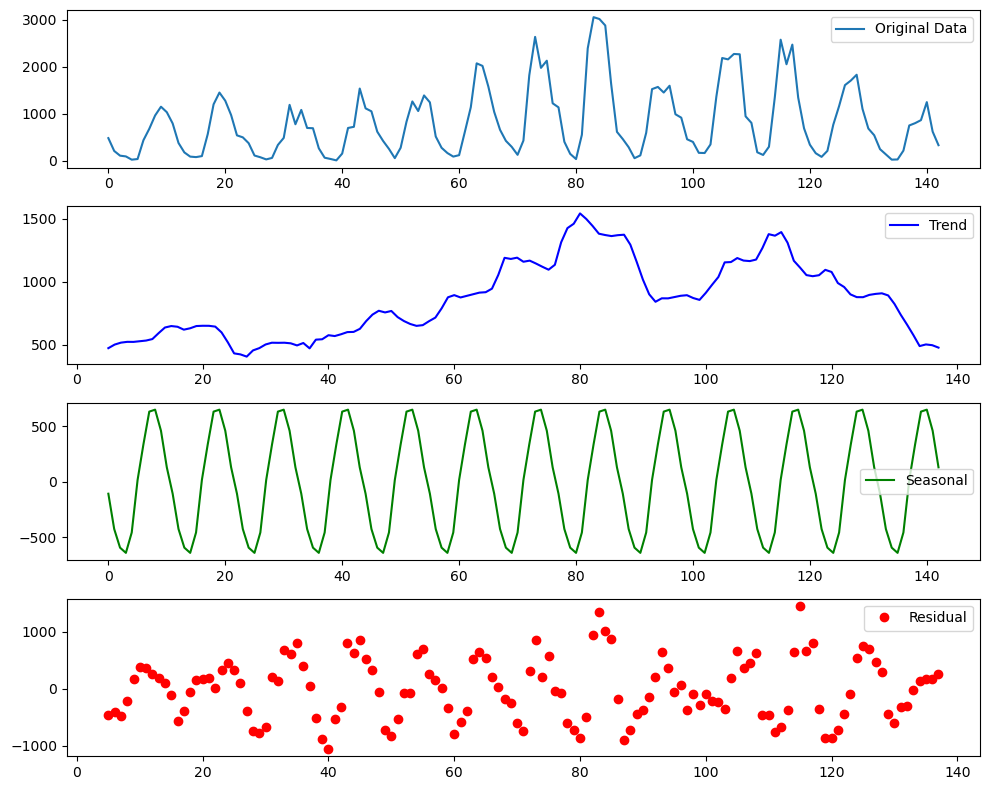

In [7]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# seasonal_decompose 함수를 사용하여 추세, 계절성 및 잔차를 계산합니다.
result = seasonal_decompose(df_copy['Total'], model='additive', period=11)

# 추세, 계절성, 잔차를 그래프로 그립니다.
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(result.observed, label='Original Data')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend', color='blue')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal', color='green')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual', color='red', marker='o', linestyle='None')
plt.legend()

plt.tight_layout()
plt.show()


# Normality (ADF, KPSS) 

In [8]:
from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    print("#### Results of Dickey-Fuller Test ####")
    dftest = adfuller(df, autolag = "AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index = [
            "Test-Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations used",
        ]
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" %key] = value
        
    print(dfoutput)

In [9]:
from statsmodels.tsa.stattools import kpss

def kpss_test(df):
    print("#### Results of KPSS Test ####")
    statistic, p_value, n_lags, critical_values = kpss(df.values)
    
    print(f"KPSS Statistic: {statistic}")
    print(f"p-value: {p_value}")
    print(f"num lags: {n_lags}")
    print(f"Critical values: {critical_values}")
    for key, value in critical_values.items():
        print(f"{key}:{value}")

In [10]:
adf_test(df_copy['Total'])
print("------------------------------------------------------------")
kpss_test(df_copy["Total"])

#### Results of Dickey-Fuller Test ####
Test-Statistic                  -1.558619
p-value                          0.504340
#Lags Used                       9.000000
Number of Observations used    133.000000
Critical Value (1%)             -3.480500
Critical Value (5%)             -2.883528
Critical Value (10%)            -2.578496
dtype: float64
------------------------------------------------------------
#### Results of KPSS Test ####
KPSS Statistic: 0.44436027438104553
p-value: 0.05803436449092866
num lags: 5
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
10%:0.347
5%:0.463
2.5%:0.574
1%:0.739


In [11]:
count_diff = df_copy["Total"].diff(11)[12:]
adf_test(count_diff)
print("------------------------------------------------------------")
kpss_test(count_diff)

#### Results of Dickey-Fuller Test ####
Test-Statistic                  -2.982868
p-value                          0.036526
#Lags Used                      11.000000
Number of Observations used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64
------------------------------------------------------------
#### Results of KPSS Test ####
KPSS Statistic: 0.28006798301584906
p-value: 0.1
num lags: 5
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
10%:0.347
5%:0.463
2.5%:0.574
1%:0.739


# ACF, PACF

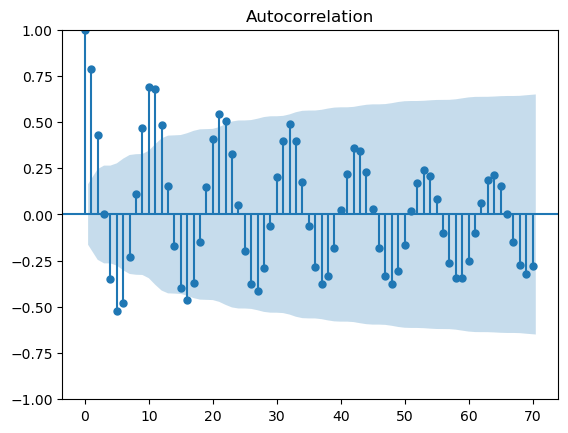

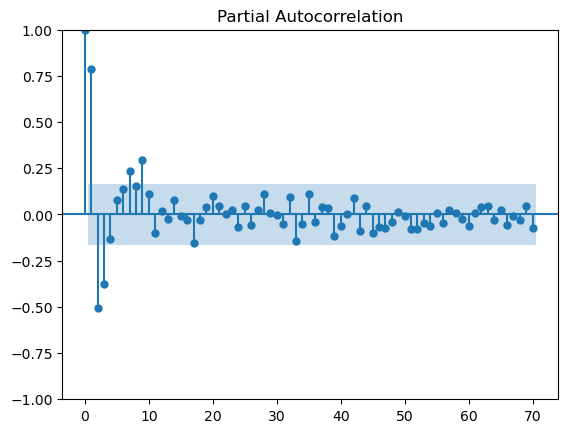

In [12]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#fig, axes = plt.subplots(2, 1, figsize=(20,15), dpi= 80)

#plot_acf(df_copy['count'], lags = 140)
#plot_pacf(df_copy['count'], lags = 140)
plot_acf(df_copy['Total'], lags = 70)
plot_pacf(df_copy['Total'], lags = 70)
plt.show()
#plot_pacf(df_copy['count'].tolist(), lags=20, ax=axes[1])

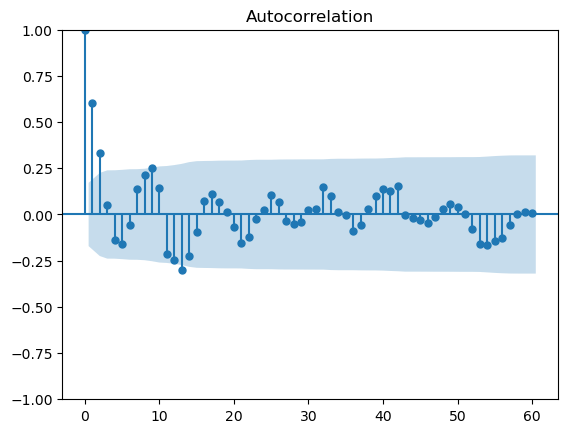

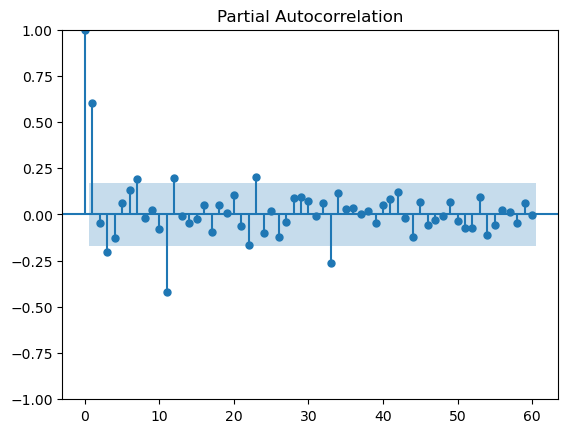

In [13]:
#plot_acf(count_diff, lags = 140)
#plot_pacf(count_diff, lags = 140)

plot_acf(count_diff, lags = 60)
plot_pacf(count_diff, lags = 60)
plt.show()

# Prediction on Time-series

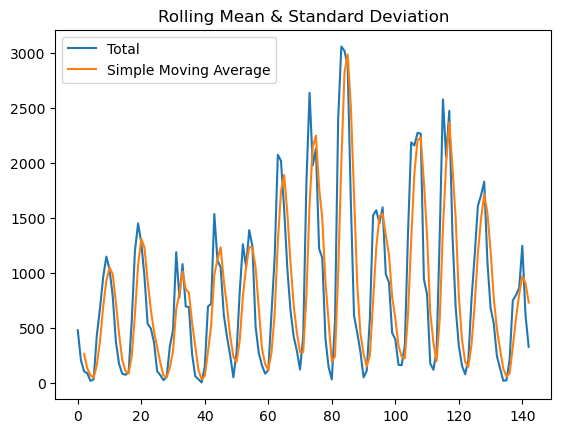

In [14]:
# Simple Moving Average
df_copy['Total'][:200].plot()
df_copy['Total'][:200].rolling(3).mean().plot(label='Simple Moving Average') 
plt.legend()
plt.title('Rolling Mean & Standard Deviation')
plt.show()

In [15]:
def wma(weights): 
    def calc(x):
        return (weights*x).mean()
    return calc

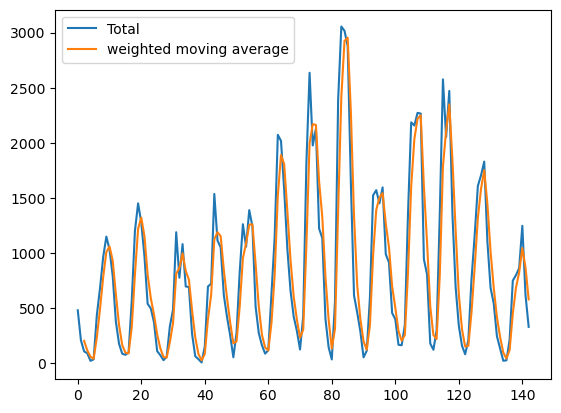

In [16]:
# weighted moving average
df_copy['Total'][:200].plot()
df_copy['Total'][:200].rolling(3).apply(wma(np.array([0.5,1,1.5]))).plot(label='weighted moving average')
plt.legend()
plt.show()

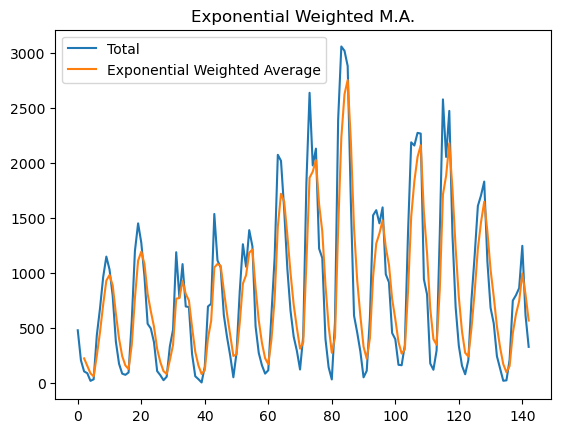

In [17]:
# Exponential Weighted Average
df_copy['Total'][:200].plot()
df_copy['Total'][:200].ewm(span=3, adjust=False, min_periods=3).mean().plot(label='Exponential Weighted Average')
plt.title('Exponential Weighted M.A.')
plt.legend()
plt.show()

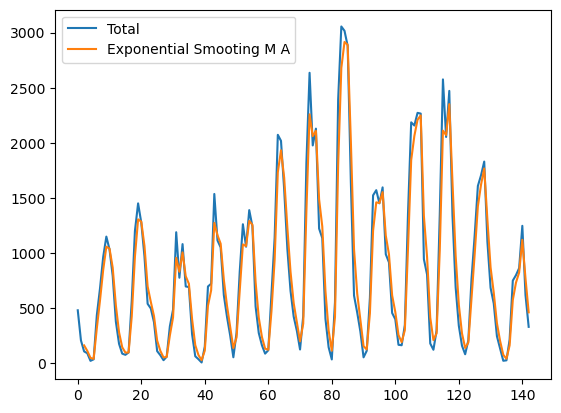

In [18]:
# Exponential Smooting M A
df_copy['Total'][:200].plot()
df_copy['Total'][:200].ewm(alpha=0.7, adjust=False, min_periods=3).mean().plot(label='Exponential Smooting M A')
plt.legend()
plt.show()

        date       Total  Month  nth_year  Rolling mean       W_M_A  \
0 1874-01-01  481.024490      1         4           NaN         NaN   
1 1875-01-01  207.747945      1         5           NaN         NaN   
2 1876-01-01  107.743169      1         6    265.505201  203.291648   
3 1877-01-01   91.463014      1         7    135.651376  116.270554   
4 1878-01-01   22.167123      1         8     73.791102   59.528428   

        E_W_A     E_S_M_A  
0  481.024490         NaN  
1  344.386218         NaN  
2  226.064693  162.339491  
3  158.763854  112.725957  
4   90.465488   49.334773  


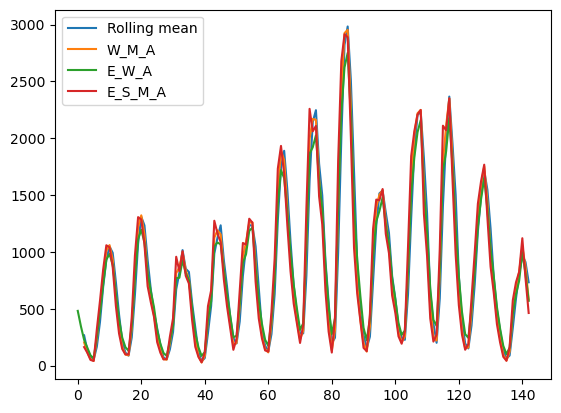

{'Rolling_Mean_RMSE': 4802.256119159745,
 'W_M_A_RMSE': 3301.2594255339945,
 'E_W_A_RMSE': 3726.5625174844095,
 'E_S_M_A_RMSE': 1977.5655808557742}

In [19]:
df_with_diff_avg=df_copy.copy()
df_with_diff_avg['Rolling mean']=df_copy['Total'].rolling(3).mean()
df_with_diff_avg['W_M_A']= df_copy['Total'].rolling(window=3).apply(wma(np.array([0.5,1,1.5])))
df_with_diff_avg['E_W_A']= df_copy['Total'].ewm(span=3, adjust=False, min_periods=0).mean()
df_with_diff_avg['E_S_M_A']= df_copy['Total'].ewm(alpha=0.7, adjust=False, min_periods=3).mean()
print(df_with_diff_avg.head())

#df_with_diff_avg.set_index('Date', inplace=True)
df_with_diff_avg[["Rolling mean", "W_M_A", "E_W_A", "E_S_M_A"]].plot()
plt.show()

df_with_diff_avg.dropna(inplace=True)
df_with_diff_avg.head()

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def RMSE_CAL(df):
    Rolling_Mean_RMSE=np.sqrt(np.sum((df.iloc[:,0]-df.iloc[:,1])**2))
    W_M_A_RMSE=np.sqrt(np.sum((df.iloc[:,0]-df.iloc[:,2])**2))
    E_W_A_RMSE=np.sqrt(np.sum((df.iloc[:,0]-df.iloc[:,3])**2))
    E_S_M_A_RMSE=np.sqrt(np.sum((df.iloc[:,0]-df.iloc[:,4])**2))
    return {"Rolling_Mean_RMSE":Rolling_Mean_RMSE,"W_M_A_RMSE":W_M_A_RMSE,"E_W_A_RMSE":E_W_A_RMSE,"E_S_M_A_RMSE":E_S_M_A_RMSE}

RMSE_CAL(df_with_diff_avg[["Total","Rolling mean", "W_M_A", "E_W_A", "E_S_M_A"]])

In [20]:
df_copy = df_copy.set_index('date')

SARIMA (0, 0, 0)x(0, 0, 0, 11): 1423.500416629533
SARIMA (0, 0, 0)x(0, 0, 1, 11): 1362.4426269996209
SARIMA (0, 0, 0)x(0, 0, 2, 11): 1339.8846153864595
SARIMA (0, 0, 0)x(1, 0, 0, 11): 1315.9927463914255
SARIMA (0, 0, 0)x(1, 0, 1, 11): 1315.0680480025387
SARIMA (0, 0, 0)x(1, 0, 2, 11): 1316.5749954529272
SARIMA (0, 0, 0)x(2, 0, 0, 11): 1314.8320540253906
SARIMA (0, 0, 0)x(2, 0, 1, 11): 1316.879170237304
SARIMA (0, 0, 0)x(2, 0, 2, 11): 1319.0760390383844
SARIMA (0, 0, 1)x(0, 0, 0, 11): 1351.4423391074993
SARIMA (0, 0, 1)x(0, 0, 1, 11): 1325.1556004123433
SARIMA (0, 0, 1)x(0, 0, 2, 11): 1302.2580989359321
SARIMA (0, 0, 1)x(1, 0, 0, 11): 1289.5564499610045
SARIMA (0, 0, 1)x(1, 0, 1, 11): 1291.505333158728
SARIMA (0, 0, 1)x(1, 0, 2, 11): 1302.9837528727248
SARIMA (0, 0, 1)x(2, 0, 0, 11): 1291.489664676391
SARIMA (0, 0, 1)x(2, 0, 1, 11): 1293.542697288067
SARIMA (0, 0, 1)x(2, 0, 2, 11): 1295.50499107924
SARIMA (0, 0, 2)x(0, 0, 0, 11): 1302.3662188837866
SARIMA (0, 0, 2)x(0, 0, 1, 11): 1291.7

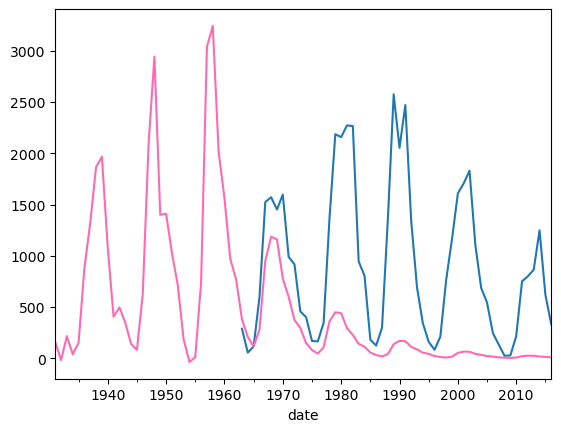

(<Figure size 1600x1000 with 4 Axes>,)

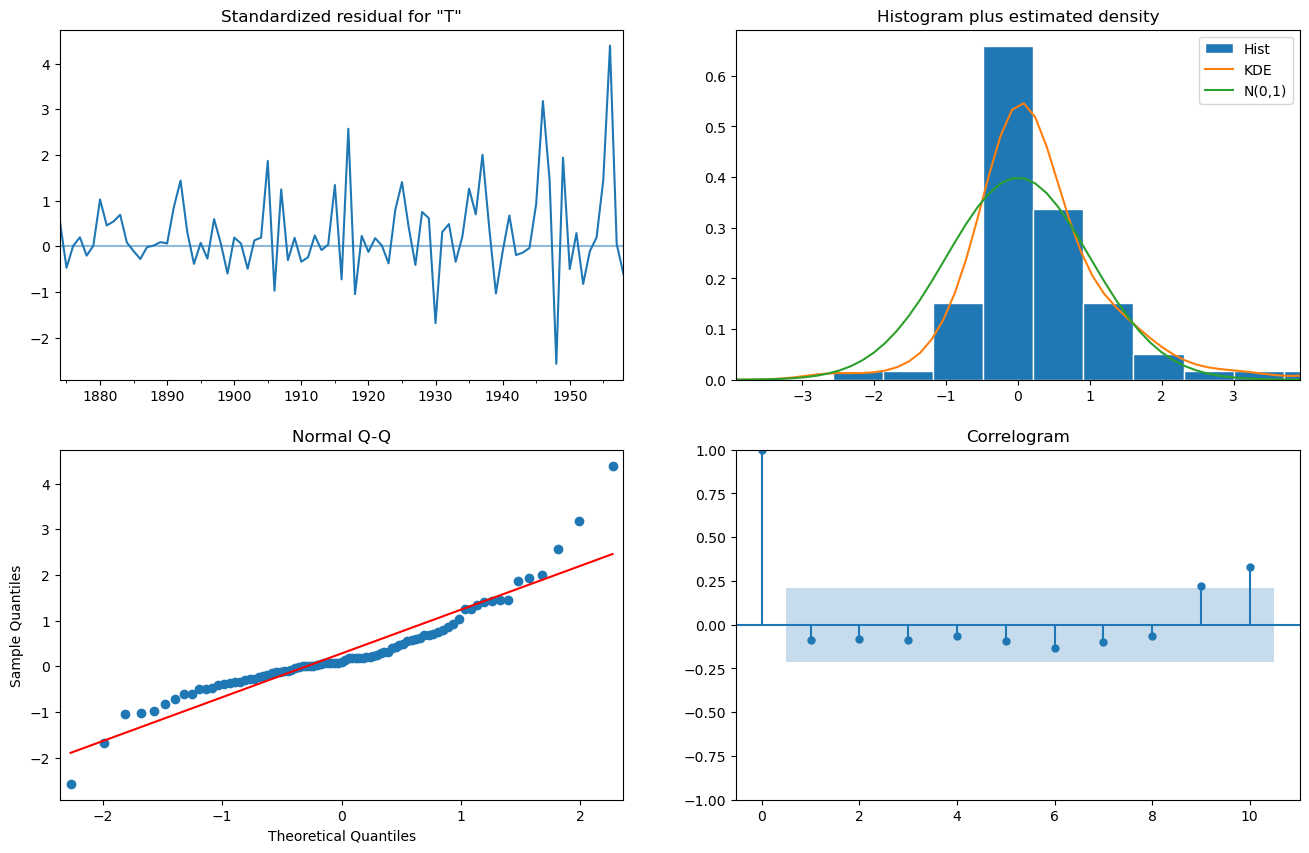

In [21]:
# SARIMA

def find_best_model(series, pdq_lst, s_pdq_lst, trans=False):

    train=series[:int(len(series)*0.6)]
    test=series[int(len(series)*0.4):]

    best_aic=np.inf
    best_pdq=None
    best_s_pdq=None
    best_model=None
    best_res=None

    for pdq in pdq_lst:
        for s_pdq in s_pdq_lst:
            try:
                tmp_model=SARIMAX(train, order=pdq, seasonal_order=s_pdq, exog=None)
                tmp_res=tmp_model.fit(disp=0)
                print('SARIMA {}x{}: {}'.format(pdq, s_pdq, tmp_res.aic))
                if tmp_res.aic<best_aic:
                    best_aic=tmp_res.aic
                    best_pdq=pdq
                    best_s_pdq=s_pdq
                    best_model=tmp_model
                    best_res=tmp_res
            except:
                print('error')

            

    print('\nbest_model SARIMA')
    print('nonseasonal {}, seasonal {}'.format(best_pdq, best_s_pdq))
    print(best_res.summary())

    pred=best_res.get_prediction(start=pd.to_datetime('1931-01-01'), end=pd.to_datetime('2016-01-01')).predicted_mean

    if trans=='sqrt':
        pred_val=np.power(pred, 2)
        test_val=np.power(test, 2)
        ax=np.power(series[100-11:], 2).plot()
    elif trans=='log':
        pred_val=np.exp(pred)-1
        test_val=np.exp(test)-1
        ax=(np.exp(series[100-11:])-1).plot()
    else:
        pred_val=pred
        test_val=test
        ax=series[100-11:].plot()    
    pred_val.plot(ax=ax, color='hotpink')
    rmse=np.sqrt(mean_squared_error(pred_val, test_val))
    
    print('\n******************')
    print('RMSE: %.2f'%(rmse))
    print('******************\n')
    
    return best_res, ax

p=q=range(0, 3)
d=range(0, 1)

P=Q=range(0, 3)
D=range(0, 1)
S=range(11, 12)

pdq_lst=list(itertools.product(p, d, q))
s_pdq_lst=list(itertools.product(P, D, Q, S))


res, ax=find_best_model(df_copy["Total"], pdq_lst, s_pdq_lst)
plt.show()
res.plot_diagnostics(figsize=(16, 10)), 